# Deep Learning 

### Import Packages

In [0]:
from keras.engine.topology import Layer
from keras.models import Sequential, Model
from keras.layers import Lambda, Input, Dense, Multiply, Add, Reshape, Flatten, Dropout, Activation, BatchNormalization, regularizers, Conv2D, MaxPooling2D
from keras.losses import mse, binary_crossentropy
from keras.layers.convolutional import Convolution2D, Conv2DTranspose, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.layers.merge import _Merge
import os, time
import numpy as np
import tensorflow as tf
import pandas as pd
from functools import partial
import pickle
from sklearn import svm
from sklearn.model_selection import cross_val_score
from google.colab import files
from PIL import Image
from matplotlib.pyplot import imshow
from keras.models import load_model
%matplotlib inline

###Program Parameters

In [0]:
# seed 
np.random.seed(2018)
tf.set_random_seed(2018)
# save data to drive
SAVE_RESULTS_TO_DRIVE = True
FOLDER_ID = 'xxxxx'
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Fashion Mnist Data Preprocessing

In [0]:
def FM_pre_prossecing(is_vae=True):
  
  # download and get the data set
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  if is_vae:
    K.set_image_data_format('channels_first')
    # image dimention
    original_dim = 28*28
    # reshape for the VAE
    x_train = x_train.reshape(-1, original_dim) / 255.
    x_test = x_test.reshape(-1, original_dim) / 255.
    # categorical the y's
#     y_train = np_utils.to_categorical(y_train, 10)
#     y_test = np_utils.to_categorical(y_train, 10)
  else:
    K.set_image_data_format('channels_last')
    # concatenate
    X_train = np.concatenate((x_train, x_test), axis=0)
    # reshape
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    x_train = (X_train.astype(np.float32) - 127.5) / 127.5

  return (x_train, y_train), (x_test, y_test)

###Sample Data Evenly for SVM

In [0]:
def balanced_subsample(x_data, y_data, subsample_size_per_label=100, is_random=False):
  
  # shuffle in random state
  if is_random:
    np.random.shuffle(x_data), np.random.shuffle(y_data)
    
  # return values
  return_x, return_y = [], []
  
  dict_of_index =  {"0":[], "1":[], "2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[]}
  # try to add to the dict_of_index an element
  for index, (xs, ys) in enumerate(zip(x_data, y_data)):
    # extract y
#     y_tag = [index for index, val in enumerate(ys) if val == 1][0]+1
    # add new element
#     if len(dict_of_index[str(y_tag)]) < subsample_size_per_label:
    if len(dict_of_index[str(ys)]) < subsample_size_per_label:
      # add index
      dict_of_index[str(ys)].append(index)
      
  # return data
  for key, value in dict_of_index.items():
    for index in value:
      #add x data
      return_x.append(x_data[index])
      # add y data
      return_y.append(y_data[index])
  
  return np.array(return_x), np.array(return_y)

###Drive REST API

In [0]:
def set_drive_api():
  # connect to drive
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  from google.colab import files

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive

  # PyDrive reference:
  # https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html
  
drive = set_drive_api()

### Save Model & Results to Google Drive

In [0]:
def save_model_wigths_to_drive(my_model, saved_file_name):
  # save weight locally on colab
  my_model.save_weights(saved_file_name)
  try:
    # try to connect to drive
    set_drive_api()
    # save to drive
    save(full_model_name)
  except:
    print("can't save exsiting model wigths to drive")
  
def save(file_name):
  # 2. Create & upload a file json file to drive
  uploaded = drive.CreateFile({'title': file_name, "parents": [{"kind": "drive#fileLink","id": FOLDER_ID}]})
  uploaded.SetContentFile(file_name)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

###Upload Saved Results

In [0]:
def load_model_wigths_by_file_name(my_model, file_name, from_local_pc=False):
  if not from_local_pc:
    try:
      # try to connect to drive
      set_drive_api()
      # try to download the file
      restord_model_wigths_file_name = dowanload_file_drive_by_file_name(file_name)
      # load the wigths
      my_model.load_weights(restord_model_wigths_file_name)
    except: 
      print("can't load exsiting model weights")
  else:
    # remove  exsixting copies
    try:
      os.remove(file_name)
    except: pass
    # upload wights files from local file system
    uploadedFiles = files.upload()
    try:
      my_model.load_weights(file_name)
    except:
      print("can't load exsiting model wigths")
  return my_model
      
def dowanload_file_drive_by_file_name(file_name):
  # choose a local (colab) directory to store the data.
  local_download_path = os.path.expanduser('~/data')
  try:
    os.makedirs(local_download_path)
  except: pass
  
  # try to remove last file with the same name
  try:
    os.remove('/root/data/{}'.format(file_name))
  except: pass
  
  file_list = drive.ListFile({'q': "'"+FOLDER_ID+"' in parents"}).GetList()
  
  for f in file_list:
    # 3. Create & download by id.
    if f['title'] == file_name:
      print('title: %s, id: %s' % (f['title'], f['id']))
      fname = os.path.join(local_download_path, f['title'])
      print('downloading to {}'.format(fname))
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      return fname

###Variational AutoEncoder

In [0]:
# adding Layer for KL Divergence
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence to the final model loss."""

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -K.square(mu) -K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


# VAE model
class VAEModel:
  
  def __init__(self, original_dim = 784, intermediate_dim = 600, latent_dim = 50):
    self.original_dim = original_dim
    self.intermediate_dim = intermediate_dim
    self.latent_dim = latent_dim
    
    # -- encoder --
    x = Input((self.original_dim,))
#     h_1 = Dense(self.intermediate_dim, activation='softplus')(x)
    h_2 = Dense(self.intermediate_dim, activation='softplus')(x)
   
    # get mean and variance
    z_mu = Dense(self.latent_dim)(h_2)
    z_log_var = Dense(self.latent_dim)(h_2)
    
    # feeding the paramters to the new Layer
    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

    # add the sampling to the model
    eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], self.latent_dim)))
    
    # transformation to get z
    z_eps = Multiply()([z_sigma, eps])
    z = Add()([z_mu, z_eps])
    
    self.encoder = Model(x, z_mu)
    
    # -- decoder --
    self.decoder = Sequential([
    Dense(self.intermediate_dim, input_dim=self.latent_dim, activation='softplus'),
#     Dense(self.intermediate_dim, activation='softplus'),
    Dense(self.original_dim, activation='sigmoid')])
    
    # get the decoder results
    x_pred = self.decoder(z)
    
    # end-to-end autoencoder build and complie the model
    self.vae = Model(inputs=[x, eps], outputs=x_pred)
    self.vae.compile(optimizer='rmsprop', loss=self.nll)
    

  def nll(self, y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    
  def get_vae_model(self):
    return self.vae
  
  def get_encoder(self):
    return self.encoder
  
  def get_decoder(self):
    return self.decoder

### Train VAE

In [0]:
def train_VAE(to_plot=True):
  # get the model
  vae = vae_class.get_vae_model()
  # train the model
  hist = vae.fit(x_train, x_train, shuffle=True, epochs=50, batch_size=128, validation_data=(x_test, x_test))
  # plot loss graph
  if to_plot:
    ax = pd.DataFrame(hist.history).plot(title='Loss (NELBO) convergence',lw=2, colormap='jet', marker='.', markersize=10)
    ax.set_xlabel("epochs")
    ax.set_ylabel("NELBO")
  # save the model
  if SAVE_RESULTS_TO_DRIVE:
    set_drive_api()
    model_type = {"VAE":"none"}
    save_model_to_drive(model_type, vae)
    save_resluts_to_drive_as_txt(model_type, hist.history['loss'], hist.history['val_loss'])
  

###Run VAE Training

4423680/4422102 [==============================] - 1s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 104us/step - loss: 303.4479 - val_loss: 281.6887
Epoch 2/50
60000/60000 [==============================] - 4s 71us/step - loss: 273.8211 - val_loss: 272.5722
Epoch 3/50
60000/60000 [==============================] - 4s 71us/step - loss: 265.1899 - val_loss: 262.7635
Epoch 4/50
60000/60000 [==============================] - 4s 70us/step - loss: 260.2535 - val_loss: 261.9590
Epoch 5/50
60000/60000 [==============================] - 4s 71us/step - loss: 256.7718 - val_loss: 256.2712
Epoch 6/50
60000/60000 [==============================] - 4s 71us/step - loss: 254.4683 - val_loss: 254.3220
Epoch 7/50
60000/60000 [==============================] - 4s 70us/step - loss: 252.8025 - val_loss: 255.5479
Epoch 8/50
60000/60000 [==============================] - 4s 70us/step - loss: 251.5547 - val_loss: 251.1141
Epoch 9/50
600

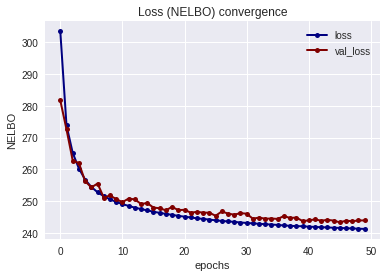

In [0]:
# build class model
vae_class = VAEModel()
# get the data
(x_train, y_train), (x_test, y_test) = FM_pre_prossecing()
# train the model
train_VAE()

###Test VAE

In [0]:
model_filename = "model_VAE.h5"
# download from drive and build the VAE model
restord_file_name = dowanload_file_drive_by_file_name(model_filename)
# crate the custom class
restored_vae_model = VAEModel()
# load the wights
restored_vae_model.vae.load_weights(restord_file_name)
# evaluate model loss on x_test
restored_loss = restored_vae_model.vae.evaluate(x_test, x_test)
print("restored VAE model loss on x_test: {}".format(restored_loss))

title: model_VAE.h5, id: 1Zxp1H4nFtCxP70fqiSaQBcr-kd36cQAP
downloading to /root/data/model_VAE.h5
10000/10000 [==============================] - 1s 68us/step
restored VAE model loss on x_test: 243.82914182128906


###TRANSDUCTIVE SVM

In [0]:
# get the encoder
encoder = vae_class.get_encoder()
# create list for the results
label_sizes = [100, 600, 1000, 3000]
mean_accuracys = []
mean_errors = []
stds = []

# set drive
set_drive_api()
# run on the diffrent label sizes
for label_size in label_sizes:
  # get the blanced data
  x, y = balanced_subsample(x_train, y_train, subsample_size_per_label=label_size)
  # use the encoder to generate the encode data
  x_tag = encoder.predict(x)
  # use simple svm classifer 
  clf = svm.SVC(gamma='scale')
  # preform cross validation of 10 models
  scores = cross_val_score(clf, x_tag, y, cv=10)
  # cross validation copy the model and don't save it
  # becuse of that we will run fit() again to save the fitted model, 
  # there might be differences between the results and the restored model
  clf.fit(x_tag, y)
  mean, std = np.mean(scores), np.std(scores)
  error = 1-mean
  # add results to list
  mean_accuracys.append(mean)
  mean_errors.append(error)
  stds.append(std)
  print("label size: {}, mean accuracy score: {}, std of accuracy: {}, mean error: {}.".format(label_size, mean, std, error))
  # save the model to disk
  filename = 'svm_model_{}.sav'.format(label_size)
  pickle.dump(clf, open(filename, 'wb'))
  # upload to drive
  save(filename)

# summarize the results in the df and save it to drive
model_results = "svm_model_results.txt"
svm_results_df = pd.DataFrame({'label_size': label_sizes, 'mean_accuracy':mean_accuracys, 'mean_error':mean_errors, 'stds':stds})
# write results locally
svm_results_df.to_csv(model_results, header=None, index=None, sep=' ')
# upload to drive
save(model_results)


label size: 100, mean accuracy score: 0.8140000000000001, std of accuracy: 0.03903844259188627, mean error: 0.18599999999999994.
Uploaded file with ID 16ZTBwwi7xUAPPSxhh-Hcl6lUFZO_rqnH
label size: 600, mean accuracy score: 0.8470000000000001, std of accuracy: 0.013494854986664796, mean error: 0.1529999999999999.
Uploaded file with ID 1Ce8PDjc-LCIhrZu_3CYSN6DvIWgfSkll
label size: 1000, mean accuracy score: 0.8486, std of accuracy: 0.007657675887630665, mean error: 0.15139999999999998.
Uploaded file with ID 1Ye5x7_gufAzrk5Iy33-HpGqbPiY0EljP
label size: 3000, mean accuracy score: 0.8603333333333334, std of accuracy: 0.00408520365329428, mean error: 0.1396666666666666.
Uploaded file with ID 1lTnYpscSAsniR7fVjDqD1fStsjn2EhHW
Uploaded file with ID 1xw12DhVEVIQNiR-y2MrIskYAvNxoySwq


###Test TRANSDUCTIVE SVM

In [0]:
# load TRANSDUCTIVE SVM model according to your label size
label_size = 1000
filename = 'svm_model_{}.sav'.format(label_size)
set_drive_api()

# get the encoder from the model 
restored_encoder = restored_vae_model.get_encoder()
# download model from drive to dick
restord_file_name_svm = dowanload_file_drive_by_file_name(filename)
# load the model from disk
loaded_svm_model = pickle.load(open(restord_file_name_svm, 'rb'))

x_for_test, y_of_test = balanced_subsample(x_train, y_train, subsample_size_per_label=label_size)
# use the encoder to generate the encode data
x_tag_x_for_test = restored_encoder.predict(x_for_test)
# get the results from the the pretrained model
result = loaded_svm_model.score(x_tag_x_for_test, y_of_test)
print("Restored model results accuracy : {}, for number of labels: {}.".format(result, label_size))

title: svm_model_1000.sav, id: 1Ye5x7_gufAzrk5Iy33-HpGqbPiY0EljP
downloading to /root/data/svm_model_1000.sav
Restored model results accuracy : 0.8644, for number of labels: 1000.


##WGAN

In [0]:
BATCH_SIZE = 64
# The training ratio is the number of discriminator updates per generator update. The paper uses 5.
TRAINING_RATIO = 5  
GRADIENT_PENALTY_WEIGHT = 10  # As per the paper
CLIP_VALUE = 0.01
OPTIMIZER=Adam(0.0001, beta_1=0.5, beta_2=0.9)

In [0]:
class RandomWeightedAverage(_Merge):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
    between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
    Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

In [0]:
def generate_images(generator_model, number_of_images=10, is_wgan=True):
    """Feeds random seeds into the generator and tiles and saves the output to a PNG file."""
    test_image_stack = generator_model.predict(np.random.rand(number_of_images, 100))
    test_image_stack = (test_image_stack * 127.5) + 127.5
    test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
    
    image_list = [test_image_stack[i, :, :] for i in range(test_image_stack.shape[0])]
    # ploting the image to screan
    plt.figure(figsize=(10,10))
    for index, image_array in enumerate(image_list):
      plt.subplot(10, 10, index+1)
      # transform to image
      im = Image.fromarray(image_array, mode='L')
      # resize
      im = im.resize((200, 200))
      # show images
      imshow(np.asarray(im))
      plt.axis('off')
      # get gan type
      if is_wgan:
        gan_type ='wgan'
      else:
        gan_type ='dcgan'
      # save locally
      file_name = '{}_img_{}.png'.format(gan_type, index)
      im.save(file_name)
      # try save to drive
      try:
        save(file_name)
      except:
        print("could not save to drive")
    # set up the images together nicely
    plt.tight_layout()

### Wasserstein Loss

In [0]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

###Gradient Penalty

In [0]:
def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight):
    # first get the gradients:
    #   assuming: - that y_pred has dimensions (batch_size, 1)
    #             - averaged_samples has dimensions (batch_size, nbr_features)
    # gradients afterwards has dimension (batch_size, nbr_features), basically
    # a list of nbr_features-dimensional gradient vectors
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

###WGAN Generator

In [0]:
def build_wgan_generator():
  """Creates a generator model that takes a 100-dimensional noise vector as a "seed", 
  and outputs images of size 28x28x1."""
  model = Sequential()
  model.add(Dense(1024))
  model.add(LeakyReLU())
  model.add(Dense(128 * 7 * 7))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Reshape((7, 7, 128), input_shape=(128 * 7 * 7,)))
  model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
  model.add(BatchNormalization(axis=3))
  model.add(LeakyReLU())
  model.add(Convolution2D(64, (5, 5), padding='same'))
  model.add(BatchNormalization(axis=3))
  model.add(LeakyReLU())
  model.add(Conv2DTranspose(64, (5, 5), strides=2, padding='same'))
  model.add(BatchNormalization(axis=3))
  model.add(LeakyReLU())
  # Because we normalized training inputs to lie in the range [-1, 1],
  # the tanh function should be used for the output of the generator to ensure its output
  # also lies in this range.
  model.add(Convolution2D(1, (5, 5), padding='same', activation='tanh'))

  return model

### WGAN Discriminator

In [0]:
def build_wgan_discriminator():
  """Creates a discriminator model that takes an image as input and outputs a single value, representing whether
  the input is real or generated."""
  model = Sequential()
  model.add(Convolution2D(64, (5, 5), padding='same', input_shape=(28, 28, 1)))
  model.add(LeakyReLU())
  model.add(Convolution2D(128, (5, 5), kernel_initializer='he_normal', strides=[2, 2], data_format = 'channels_last'))
  model.add(LeakyReLU())
  model.add(Convolution2D(128, (5, 5), kernel_initializer='he_normal', padding='same', strides=[2, 2]))
  model.add(LeakyReLU())
  model.add(Flatten())
  model.add(Dense(1024, kernel_initializer='he_normal'))
  model.add(LeakyReLU())
  model.add(Dense(1, kernel_initializer='he_normal'))

  return model

### Setup WGAN for Training

In [0]:
class WGAN:
  
  def __init__(self):
    
    # get the data
    (self.x_train, _), (_, _) = FM_pre_prossecing(False)

    # initialize the generator and discriminator.
    self.wgan_generator = build_wgan_generator()
    self.wgan_discriminator = build_wgan_discriminator()

    # The generator_model is used when we want to train the generator layers.
    # As such, we ensure that the discriminator layers are not trainable.
    for layer in self.wgan_discriminator.layers:
        layer.trainable = False
    self.wgan_discriminator.trainable = False

    generator_input = Input(shape=(100,))
    generator_layers = self.wgan_generator(generator_input)
    discriminator_layers_for_generator = self.wgan_discriminator(generator_layers)
    self.wgan_generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])

    # We use the Adam paramaters from Gulrajani et al.
    self.wgan_generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)

    # Now that the generator_model is compiled, we can make the discriminator layers trainable.
    for layer in self.wgan_discriminator.layers:
        layer.trainable = True
    for layer in self.wgan_generator.layers:
        layer.trainable = False
    self.wgan_discriminator.trainable = True
    self.wgan_generator.trainable = False

    # The discriminator_model is more complex. 
    # It takes both real image samples and random noise seeds as input.
    # The noise seed is run through the generator model to get generated images. 
    # Both real and generated images
    # are then run through the discriminator. 
    real_samples = Input(shape=x_train.shape[1:])
    generator_input_for_discriminator = Input(shape=(100,))
    generated_samples_for_discriminator = self.wgan_generator(generator_input_for_discriminator)
    discriminator_output_from_generator = self.wgan_discriminator(generated_samples_for_discriminator)
    discriminator_output_from_real_samples = self.wgan_discriminator(real_samples)

    # We also need to generate weighted-averages of real and generated samples, to use for the gradient norm penalty.
    averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
    # We then run these samples through the discriminator as well.
    averaged_samples_out = self.wgan_discriminator(averaged_samples)

    # keras limitations
    partial_gp_loss = partial(gradient_penalty_loss,
                              averaged_samples=averaged_samples,
                              gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
    partial_gp_loss.__name__ = 'gradient_penalty'  


    self.wgan_discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator],
                                outputs=[discriminator_output_from_real_samples, discriminator_output_from_generator, averaged_samples_out])

    # We use the Wasserstein loss for both the real and generated samples,
    # and the gradient penalty loss for the averaged samples.
    self.wgan_discriminator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                                loss=[wasserstein_loss, wasserstein_loss, partial_gp_loss])

    # We make three label vectors for training. positive_y is the label vector for real samples, with value 1.
    # negative_y is the label vector for generated samples, with value -1. The dummy_y vector is passed to the
    # gradient_penalty loss function and is not used.
    self.positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
    self.negative_y = -positive_y
    self.dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)
    
  def train_WGAN(self, number_of_epochs, save_results=True, generate_new_images=True, load_exsiting_model=True, plot_loss=True, use_clip_weights=False):

    # file names
    wgan_discriminator_model_wigths_file_name = 'wgan_discriminator_model_wigths.h5'
    wgan_generator_model_wigths_file_name = 'wgan_generator_model_wigths.h5'
    wgan_generator_file_name = 'wgan_generator_wigths.hdf5'

    if load_exsiting_model:
      self.wgan_discriminator_model = load_model_wigths_by_file_name(self.wgan_discriminator_model, wgan_discriminator_model_wigths_file_name)
      self.wgan_generator_model = load_model_wigths_by_file_name(self.wgan_generator_model, wgan_generator_model_wigths_file_name)
#       self.wgan_generator = load_model_wigths_by_file_name(self.wgan_generator, wgan_generator_wigths_file_name)

    # shuffel the data
    np.random.shuffle(self.x_train)

    # masure total training time
    t0 = time.time()

    # end of epoch lists
    self.wgan_discriminator_end_of_epoch_loss = []
    self.wgan_generator_loss = []
    
    for epoch in range(number_of_epochs):

      # masure epoch training time
      t2 = time.time()

      # ---------------------
      #  Train Discriminator
      # ---------------------

      print("Epoch: ", epoch)
      print("Number of batches: ", int(self.x_train.shape[0] // BATCH_SIZE))

      self.wgan_discriminator_loss = []
      
      minibatches_size = BATCH_SIZE * TRAINING_RATIO

      for i in range(int(self.x_train.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        discriminator_minibatches = self.x_train[i * minibatches_size:(i + 1) * minibatches_size]

        for j in range(TRAINING_RATIO):
          image_batch = discriminator_minibatches[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]
          noise = np.random.rand(BATCH_SIZE, 100).astype(np.float32)
          self.wgan_discriminator_loss.append(self.wgan_discriminator_model.train_on_batch([image_batch, noise], 
                                                                                           [self.positive_y, self.negative_y, self.dummy_y]))
      # add last loss to the list
      self.wgan_discriminator_end_of_epoch_loss.append(self.wgan_discriminator_loss[-1][0])
      
      if use_clip_weights:
        # Clip discriminator weights
        for l in self.wgan_discriminator_model.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -CLIP_VALUE, CLIP_VALUE) for w in weights]
            l.set_weights(weights)

      # ---------------------
      #  Train Generator
      # ---------------------

      self.wgan_generator_loss.append(self.wgan_generator_model.train_on_batch(np.random.rand(BATCH_SIZE, 100), self.positive_y))

      t3 = time.time()
      print("Epoch training time: %0.2fs" % (t3 - t2))

    t1 = time.time()
    print("Total training time: %0.2fs" % (t1 - t0))
    
    # summarize the results in the df    
    wgan_results_df = pd.DataFrame({"generator_loss": self.wgan_generator_loss, "discriminator_loss":self.wgan_discriminator_end_of_epoch_loss})

    if save_results:

      # save wights locally 
      # -- for retrain --
      self.wgan_discriminator_model.save_weights(wgan_discriminator_model_wigths_file_name)
      self.wgan_generator_model.save_weights(wgan_generator_model_wigths_file_name)
      # -- for generation of new images -- 
      self.wgan_generator.save(wgan_generator_file_name)

      # upload to drive
      set_drive_api()
      save(wgan_discriminator_model_wigths_file_name)
      save(wgan_generator_model_wigths_file_name)
      save(wgan_generator_file_name)

      # write results locally
      model_results = "wgan_model_results.txt"
      wgan_results_df.to_csv(model_results, header=None, index=None, sep=' ')
      # upload to drive
      save(model_results)

    if plot_loss:
      ax = wgan_results_df.plot(title='Loss Per Epochs',lw=2, colormap='jet', marker='.', markersize=10)
      ax.set_xlabel("Epochs")
      ax.set_ylabel("Loss")  

###Train WGAN

In [0]:
# set up wgan instance
wgan = WGAN()
# train it
wgan.train_WGAN(2, plot_loss=False, load_exsiting_model=True)

title: wgan_discriminator_model_wigths.h5, id: 1uTf11euZ5WaJpUC5xeO_gGPnQTLOQU8c
downloading to /root/data/wgan_discriminator_model_wigths.h5
title: wgan_generator_model_wigths.h5, id: 1aUviWuzH71Qhh6KCw2JgZDDwDKY3-wyJ
downloading to /root/data/wgan_generator_model_wigths.h5
Epoch:  0
Number of batches:  1093
Epoch training time: 116.99s
Epoch:  1
Number of batches:  1093
Epoch training time: 98.19s
Total training time: 215.18s
Uploaded file with ID 1YpyPoXraU5NgoXTfaZRYb7v5-R4lCAcf
Uploaded file with ID 1WZgwAk8CR4-QwBrwNOAJLumXqF0_x1Va
Uploaded file with ID 1Ry9UPSyW9BwlzBRppbW2oEp_AFL2ufal
Uploaded file with ID 19TxvAsu_fTBHulaRKdVAtgSfDVUhkFfi


### WGAN Genarate New Images From Loaded Model

In [0]:
# setup number of images and run the generator
# use more then 1
number_of_images = 10
# wgan_generator_wigths_file_name = 'wgan_generator_wigths.h5'
wgan_generator_file_name = 'wgan_generator_wigths.hdf5'
is_from_pc = False
run_file_name = ''

if not is_from_pc:
  # download the file from drive
  run_file_name = dowanload_file_drive_by_file_name(wgan_generator_file_name)
else:
  # upload model file from local file system
  uploadedFiles = files.upload()
  run_file_name = wgan_generator_file_name

# load the model
wgan_generator = load_model(run_file_name)
# generate images
generate_images(model, number_of_images, is_wgan=True)

## DCGAN

###DCGAN Generator

In [0]:
def build_dc_generator():
  generator = Sequential([
          Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)),
          BatchNormalization(),
          Reshape((7,7,128)),
          UpSampling2D(),
          Convolution2D(64, 5, 5, border_mode='same', activation=LeakyReLU(0.2)),
          BatchNormalization(),
          UpSampling2D(),
          Convolution2D(1, 5, 5, border_mode='same', activation='tanh')
      ])
  generator.compile(loss='binary_crossentropy', optimizer=Adam())
  return generator

###DCGAN Discriminator 

In [0]:
def build_dc_discriminator():
  discriminator = Sequential([
          Convolution2D(64, 5, 5, subsample=(2,2), input_shape=(28,28,1), border_mode='same', activation=LeakyReLU(0.2)),
          Dropout(0.3),
          Convolution2D(128, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU(0.2)),
          Dropout(0.3),
          Flatten(),
          Dense(1, activation='sigmoid')
      ])
  discriminator.compile(loss='binary_crossentropy', optimizer=Adam())
  return discriminator

### Setup DCGAN

In [0]:
class DCGAN:
  
  def __init__(self):

    # get the data
    (self.x_train, _), (_, _) = FM_pre_prossecing(False)
    # get generator and discriminator
    self.dcgan_discriminator = build_dc_discriminator()
    self.dcgan_generator = build_dc_generator()

    self.dcgan_discriminator.trainable = False
    ganInput = Input(shape=(100,))
    # getting the output of the generator
    # and then feeding it to the discriminator
    # new model = D(G(input))
    x = self.dcgan_generator(ganInput)
    ganOutput = self.dcgan_discriminator(x)
    self.dcgan = Model(input=ganInput, output=ganOutput)
    self.dcgan.compile(loss='binary_crossentropy', optimizer=Adam())
    
  def train_DCGAN(self, number_of_epochs, save_results=True, generate_new_images=True, load_exsiting_model=True, plot_loss=True):

    # file names
    dcgan_discriminator_model_wigths_file_name = 'dcgan_discriminator_model_wigths.h5'
    dcgan_generator_model_wigths_file_name = 'dcgan_generator_model_wigths.h5'
    
    if load_exsiting_model:
      self.dcgan_discriminator = load_model_wigths_by_file_name(self.dcgan_discriminator, dcgan_discriminator_model_wigths_file_name)
      self.dcgan_generator = load_model_wigths_by_file_name(self.dcgan_generator, dcgan_generator_model_wigths_file_name)

    batch_size=128
    batch_count = self.x_train.shape[0] // batch_size
    self.dcgan_discriminator_end_of_epoch_loss = []
    self.dcgan_generator_end_of_epoch_loss = []
    
    
    # shuffel the data
    np.random.shuffle(self.x_train)

    # masure total training time
    t0 = time.time()

    for epoch in range(number_of_epochs):

      # masure epoch training time
      t2 = time.time()

      # ---------------------
      #  Train Discriminator
      # ---------------------

      print("Epoch: ", epoch)
      
      dc_discriminator_loss = []
      dc_generator_loss = []
      
      for j in range(batch_count):
        # Input for the generator
        noise_input = np.random.rand(batch_size, 100)

        # getting random images from x_train of size=batch_size 
        # these are the real images that will be fed to the discriminator
        image_batch = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size)]

        # these are the predicted images from the generator
        predictions = self.dcgan_generator.predict(noise_input, batch_size=batch_size)

        # the discriminator takes in the real images and the generated images
        X = np.concatenate([predictions, image_batch])

        # labels for the discriminator
        y_discriminator = [0]*batch_size + [1]*batch_size

        # Let's train the discriminator
        self.dcgan_discriminator.trainable = True
        dc_discriminator_loss.append(self.dcgan_discriminator.train_on_batch(X, y_discriminator))

        # Let's train the generator
        noise_input = np.random.rand(batch_size, 100)
        y_generator = [1]*batch_size
        
        # ---------------------
        #  Train Generator
        # ---------------------
        
        self.dcgan_discriminator.trainable = False
        dc_generator_loss.append(self.dcgan.train_on_batch(noise_input, y_generator))

      t3 = time.time()
      print("Epoch training time: %0.2fs" % (t3 - t2))
  #     print("Discriminator metrics names: {}".format(discriminator_model.metrics_names))
      print("Generator loss: {}, Discriminator loss: {}".format(1 - dc_generator_loss[-1], 1 - dc_discriminator_loss[-1]))
      # add end of epoch losses
      self.dcgan_discriminator_end_of_epoch_loss.append(1 - dc_discriminator_loss[-1])
      self.dcgan_generator_end_of_epoch_loss.append(1 - dc_generator_loss[-1])

  #     if generate_new_images and epoch % 10 == 0 :
  #       generate_images(dc_generator, is_wgan=False)

    t1 = time.time()
    print("Total training time: %0.2fs" % (t1 - t0))

    # summarize the results in the df    
    dcgan_results_df = pd.DataFrame({"generator_end_of_epoch_loss": self.dcgan_generator_end_of_epoch_loss, 
                                     "discriminator_end_of_epoch_loss":self.dcgan_discriminator_end_of_epoch_loss})
    if save_results:
      # save wights locally 
      self.dcgan_discriminator.save_weights(dcgan_discriminator_model_wigths_file_name)
      self.dcgan_generator.save_weights(dcgan_generator_model_wigths_file_name)

      set_drive_api()
      # upload to drive
      save(dcgan_discriminator_model_wigths_file_name)
      save(dcgan_generator_model_wigths_file_name)

      # write results locally
      model_results = "dcgan_model_results.txt"
      dcgan_results_df.to_csv(model_results, header=None, index=None, sep=' ')
      # upload to drive
      save(model_results)

    if plot_loss:
      ax = dcgan_results_df.plot(title='Loss Per Epochs',lw=2, colormap='jet', marker='.', markersize=10)
      ax.set_xlabel("Epochs")
      ax.set_ylabel("Loss")


### Train DCGAN

In [0]:
# set up wgan instance
dcgan = DCGAN()
# train it
dcgan.train_DCGAN(5, generate_new_images=False, load_exsiting_model=True, plot_loss=False)

title: dcgan_discriminator_model_wigths.h5, id: 1G3qmrH0XVRRoVeRf9ltVNz8Zlaz3aaxh
downloading to /root/data/dcgan_discriminator_model_wigths.h5
title: dcgan_generator_model_wigths.h5, id: 106Ame5j1uAuvo_ZMTx3y6rulCWdMt7R9
downloading to /root/data/dcgan_generator_model_wigths.h5
Epoch:  0
Epoch training time: 54.34s
Generator loss: -4.210963249206543, Discriminator loss: 0.8747262060642242
Epoch:  1
Epoch training time: 41.60s
Generator loss: -4.053496360778809, Discriminator loss: 0.9240037649869919
Epoch:  2
Epoch training time: 41.41s
Generator loss: -7.973957061767578, Discriminator loss: 0.8359526097774506
Epoch:  3
Epoch training time: 41.51s
Generator loss: -2.5970640182495117, Discriminator loss: 0.8567473441362381
Epoch:  4
Epoch training time: 41.38s
Generator loss: -7.028169631958008, Discriminator loss: 0.9402674846351147
Total training time: 220.25s
Uploaded file with ID 1xRRzuh6zmjG6CUq2FmPQW7oxjMAeEzjU
Uploaded file with ID 1XaAcOJWx4DjWjrCrAT_rK_Fk3J8ILrlP
Uploaded file

### Genarate New Images From Exsicting DCGAN Model 

title: dcgan_generator_model_wigths.h5, id: 1XaAcOJWx4DjWjrCrAT_rK_Fk3J8ILrlP
downloading to /root/data/dcgan_generator_model_wigths.h5
Uploaded file with ID 1tn5KjmW8Vm9ml2ez_uYK11aI_GpqIMk1
Uploaded file with ID 19a4-KquzbUbOpkipgeAxKNAoYeoqPJa0
Uploaded file with ID 1cqcfuG81bYLOW0ubwP1tX3gv4l1GhCIA
Uploaded file with ID 1jSeiOumqUewQ3b3P9fK3FMWVYwd-QAoR
Uploaded file with ID 1ns4dxnZBinjDJ_s_O34VAIvQZIetk5MY
Uploaded file with ID 1mKgi7zBATt26d-9EgX5gK8vRR0uKdGdm
Uploaded file with ID 1wUzmfoNG-L2L2HmhI2stc47rElI94_aw
Uploaded file with ID 1MC3M2MCVYze6We9xwUoxHhU08sEQQOa9
Uploaded file with ID 1i2PObUwddrJxsiPyF5eaZmoGPu5Ikad-
Uploaded file with ID 1qleJZKy_EV_M-R5gLU_xSAJ2ZDH3NY97


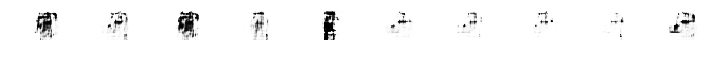

In [0]:
number_of_images = 10
file_name = 'dcgan_generator_model_wigths.h5'
is_from_pc = False
# create untrained dcgan generator 
empty_dcgan_generator = build_dc_generator()
# load wigths on the generator
new_dcgan_generator = load_model_wigths_by_file_name(empty_dcgan_generator, file_name, from_local_pc=is_from_pc)
# generate the number of images needed
generate_images(new_dcgan_generator, number_of_images, is_wgan=False)